In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

import boto3
import os

#### Settings

In [2]:
base_dir = '/home/sagemaker-user/sagemaker/02_wine_mlflow_e2e'
bucket_name = 'sagemaker-bucket-ds'
project_path_s3 = 'wine'

#### Read data

In [3]:
# Load the Wine dataset
wine = datasets.load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine['target'] = wine.target

# Lets make a binary classification
df_wine = df_wine[df_wine['target'].isin([0, 1])]

df_wine.columns = df_wine.columns.str.replace('/', '_')
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [4]:
def bin_and_create_dummies(df, column_name, thresholds):
    """
    Bin a specified column in the dataframe according to given thresholds
    and create dummy variables for the binned categories.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    column_name (str): The name of the column to be binned.
    thresholds (list): The thresholds for binning the column.

    Returns:
    pd.DataFrame: The dataframe with the binned column and corresponding dummy variables.
    list: The names of the new dummy columns created.
    """
    # Create labels based on thresholds
    labels = [f'<{thresholds[1]}'] + [f'{thresholds[i]}-{thresholds[i+1]}' for i in range(1, len(thresholds)-2)] + [f'>{thresholds[-2]}']
    
    # Bin the specified column
    df[f'{column_name}_binned'] = pd.cut(df[column_name], bins=thresholds, labels=labels)
    
    # Create dummy variables out of the binned column
    df_dummies = pd.get_dummies(df, columns=[f'{column_name}_binned'], prefix=column_name, drop_first=True)
    
    # Generate the dummy column names based on the labels
    dummy_columns = [f"{column_name}_{label}" for label in labels[1:]]
    
    # Ensure the dummy columns have values 0 and 1
    df_dummies[dummy_columns] = df_dummies[dummy_columns].astype(int)
    
    return df_dummies, dummy_columns

# Define a function to apply binning and dummy variable creation for each variable in the dictionary
def bin_and_create_dummies_for_all(df, thresholds_dict):
    all_dummy_columns = []
    df_modified = df.copy()
    
    for column, thresholds in thresholds_dict.items():
        # Add -np.inf and np.inf to the thresholds
        extended_thresholds = [-np.inf] + thresholds + [np.inf]
        
        # Apply the bin_and_create_dummies function
        df_modified, dummy_columns = bin_and_create_dummies(df_modified, column, extended_thresholds)
        
        # Collect all dummy column names
        all_dummy_columns.extend(dummy_columns)
    
    return df_modified, all_dummy_columns

# Define the thresholds dictionary
thresholds_dict = {
    'alcohol': [12, 13, 14],
    'ash': [2, 2.5],
    'color_intensity': [3, 5, 7]
}

# Apply the function to the Wine dataset
df_dummies, dummy_columns = bin_and_create_dummies_for_all(df_wine.copy(), thresholds_dict)

df = df_dummies[['target'] + dummy_columns]
df

,target,alcohol_12-13,alcohol_13-14,alcohol_>14,ash_2-2.5,ash_>2.5,color_intensity_3-5,color_intensity_5-7,color_intensity_>7
0,0,0,0,1,1,0,0,1,0
1,0,0,1,0,1,0,1,0,0
2,0,0,1,0,0,1,0,1,0
3,0,0,0,1,1,0,0,0,1
4,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...
125,1,1,0,0,1,0,0,0,0
126,1,1,0,0,1,0,1,0,0
127,1,0,0,0,0,1,0,0,0
128,1,1,0,0,1,0,0,0,0


#### Train - Test split

In [5]:
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42, stratify=df["target"])

#### Paths to files

In [6]:
data_local_path = os.path.join(base_dir, 'data') # Folder with data
train_local_path = os.path.join(data_local_path, 'train.csv') # Path to CSV file with train
test_local_path = os.path.join(data_local_path, 'test.csv') # Path to CSV file with test
infer_local_path = os.path.join(data_local_path, 'infer.csv') # Path to CSV file with inference input
column_names_path = os.path.join(data_local_path, 'column_names.csv') # Path to file with list of column names

#### Save data frames
The data frames should be in following format:
- Separated by ','
- Without headers
- Without index column
- Only target and columns used in the model
- Target column must be first

In [7]:
os.makedirs(data_local_path, exist_ok=True) # Create data folder
train_df.to_csv(train_local_path, index=False, header=None)
test_df.to_csv(test_local_path, index=False, header=None)

infer_df = test_df.drop(columns=["target"]) # In the inference input file we don't want to have target
infer_df.to_csv(infer_local_path, index=False, header=None)

column_names_list = ','.join(df.columns)
with open(column_names_path, 'w') as file:
    file.write(column_names_list)

#### Let's verify how the files look like

In [8]:
!head {train_local_path}

0,0,1,0,0,1,0,1,0
0,0,1,0,1,0,0,1,0
1,1,0,0,1,0,0,0,0
1,0,0,0,1,0,1,0,0
1,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0
1,1,0,0,1,0,0,0,0
0,0,1,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0
0,0,1,0,0,1,1,0,0


In [9]:
!head {test_local_path}

1,1,0,0,0,0,1,0,0
1,0,1,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0
1,0,1,0,1,0,1,0,0
0,0,0,1,1,0,0,0,1
1,1,0,0,1,0,0,0,0
0,0,0,1,1,0,0,1,0
0,0,1,0,1,0,0,1,0
0,0,0,1,1,0,0,1,0
1,1,0,0,0,0,0,0,0


In [10]:
!head {infer_local_path}

1,0,0,0,0,1,0,0
0,1,0,0,0,1,0,0
1,0,0,1,0,0,0,0
0,1,0,1,0,1,0,0
0,0,1,1,0,0,0,1
1,0,0,1,0,0,0,0
0,0,1,1,0,0,1,0
0,1,0,1,0,0,1,0
0,0,1,1,0,0,1,0
1,0,0,0,0,0,0,0


In [11]:
!head {column_names_path }

target,alcohol_12-13,alcohol_13-14,alcohol_>14,ash_2-2.5,ash_>2.5,color_intensity_3-5,color_intensity_5-7,color_intensity_>7

#### Copy data into S3

In [12]:
data_s3_path  = os.path.join('s3://', bucket_name, project_path_s3, 'data') 
bi_s3_path = os.path.join('s3://', bucket_name, project_path_s3, 'batch_inference_input') 

train_s3_path = os.path.join(data_s3_path, 'train.csv')
test_s3_path = os.path.join(data_s3_path, 'test.csv')
infer_s3_path = os.path.join(bi_s3_path, 'infer.csv')
columns_s3_path = os.path.join(data_s3_path, 'column_names.csv')
print(data_s3_path)

!aws s3 cp {train_local_path} {train_s3_path}
!aws s3 cp {test_local_path} {test_s3_path}
!aws s3 cp {infer_local_path} {infer_s3_path}
!aws s3 cp {column_names_path} {columns_s3_path}

s3://sagemaker-bucket-ds/wine/data
upload: data/train.csv to s3://sagemaker-bucket-ds/wine/data/train.csv
upload: data/test.csv to s3://sagemaker-bucket-ds/wine/data/test.csv
upload: data/infer.csv to s3://sagemaker-bucket-ds/wine/batch_inference_input/infer.csv
upload: data/column_names.csv to s3://sagemaker-bucket-ds/wine/data/column_names.csv


Manual inspection on S3 confirms that files are in the right folder
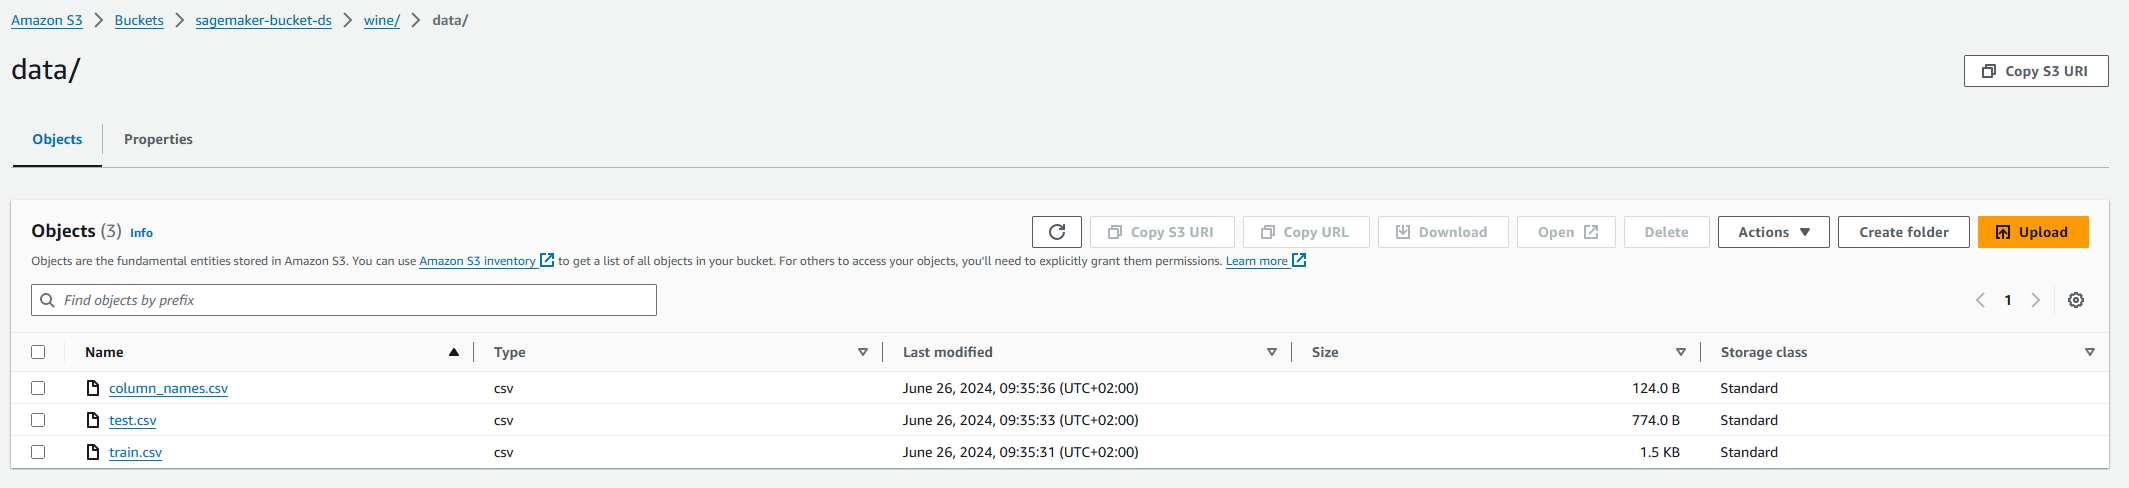